In [41]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.params import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

In [43]:
attention_df = pd.read_csv(os.path.join(data_directory, 'attention_output.csv')).sort_values(by=['timestamp', 'face_idx']).reset_index(drop=True)
attention_df.head()

,frame,timestamp,time_group,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score
0,image_ds0,0,0,0,Cedric,0.60,False,straight,0.53,straight,0.60,head left,0.44,head level,1.00
1,image_ds0,0,0,1,Lancelot,0.39,True,straight,0.56,straight,0.50,head centered,1.07,head level,1.27
2,image_ds0,0,0,2,Sara,0.37,True,straight,0.55,straight,0.45,head centered,1.25,head level,1.55
3,image_ds0,0,0,3,Gregorio,0.52,True,straight,0.57,straight,0.50,head centered,1.06,head level,1.73
4,image_ds0,0,0,4,NaN,NaN,False,straight,0.54,straight,0.39,head centered,1.22,head down,3.92


In [44]:
attention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        2154 non-null   object 
 1   timestamp                    2154 non-null   int64  
 2   time_group                   2154 non-null   int64  
 3   face_idx                     2154 non-null   int64  
 4   recognition_prediction       1700 non-null   object 
 5   recognition_distance         1729 non-null   float64
 6   attentive                    2154 non-null   bool   
 7   left_prediction              2154 non-null   object 
 8   left_score                   2154 non-null   float64
 9   right_prediction             2154 non-null   object 
 10  right_score                  2154 non-null   float64
 11  head_direction_prediction    2154 non-null   object 
 12  head_direction_score         2154 non-null   float64
 13  head_inclination_p

In [45]:
attention_df.columns

Index(['frame', 'timestamp', 'time_group', 'face_idx',
       'recognition_prediction', 'recognition_distance', 'attentive',
       'left_prediction', 'left_score', 'right_prediction', 'right_score',
       'head_direction_prediction', 'head_direction_score',
       'head_inclination_prediction', 'head_inclination_score'],
      dtype='object')

### Creating time blocks to average metrics on block

In [46]:
# grouping_factor = 10
# timestamps = attention_df.timestamp.unique()
# timestamp_dict = {timestamps[i]: timestamps[i - i % grouping_factor] for i in range(len(timestamps))}

In [47]:
# attention_df['time_group'] = attention_df['timestamp'].map(timestamp_dict)
# # attention_df

# Group metrics

### Focusing on attention

In [48]:
attention_sec = attention_df.groupby('timestamp')[['attentive']].mean()
# attention_sec.plot()

<Axes: xlabel='timestamp'>

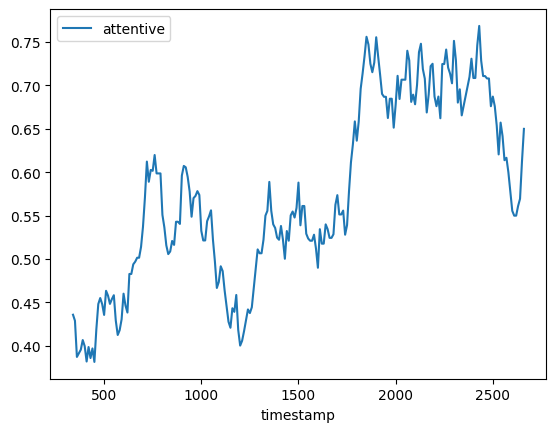

In [49]:
attention_ma = attention_sec.rolling(window=10).mean().dropna()
attention_ma.plot()

<Axes: xlabel='time_group'>

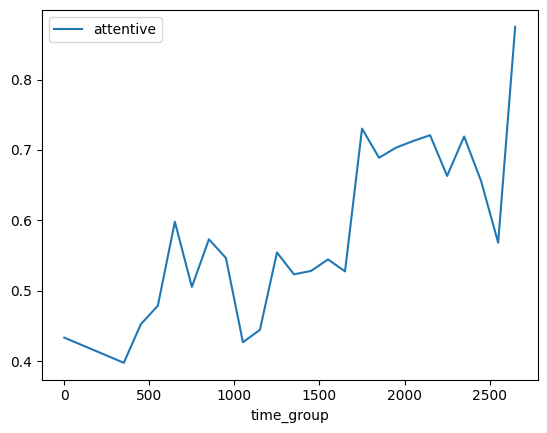

In [50]:
attention_block = attention_df.groupby('time_group')[['attentive']].mean()
attention_block.plot()

### Focus on detection

In [51]:
detection_sec = attention_df.groupby('timestamp').agg(
    {'time_group': 'first',
     'face_idx': 'count'})
# detection_sec.plot(y='attentive', use_index=True)

<Axes: xlabel='timestamp'>

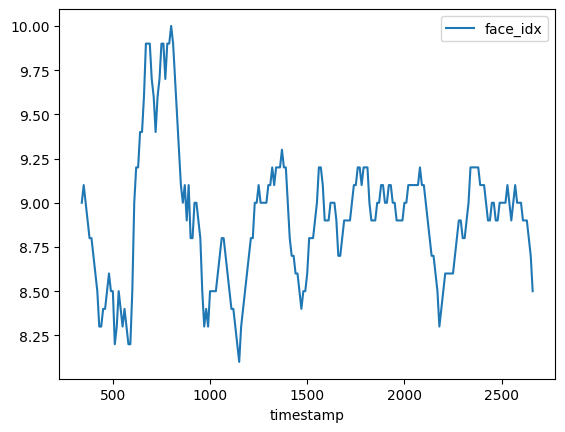

In [52]:
detection_ma = detection_sec.rolling(window=10).mean().dropna()
detection_ma.plot(y='face_idx', use_index=True)

<Axes: xlabel='time_group'>

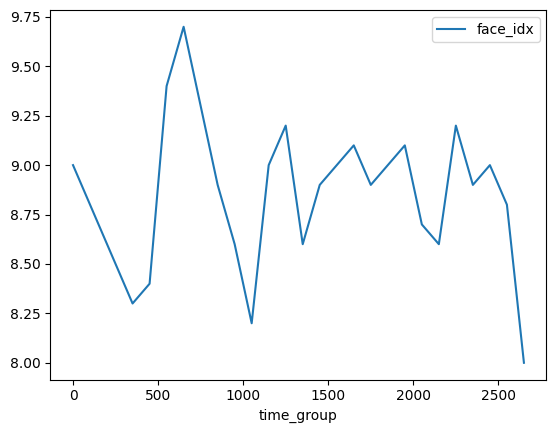

In [53]:
detection_block = detection_sec.groupby('time_group')[['face_idx']].mean()
detection_block.plot(y='face_idx', use_index=True)

### Focus on recognition

#### Number of people recognized

In [54]:
recognition_sec = attention_df.groupby(by='timestamp').agg(
    {'time_group': 'first',
     'recognition_prediction': lambda x: sum(~pd.isna(x))})
# recognition_sec.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='timestamp'>

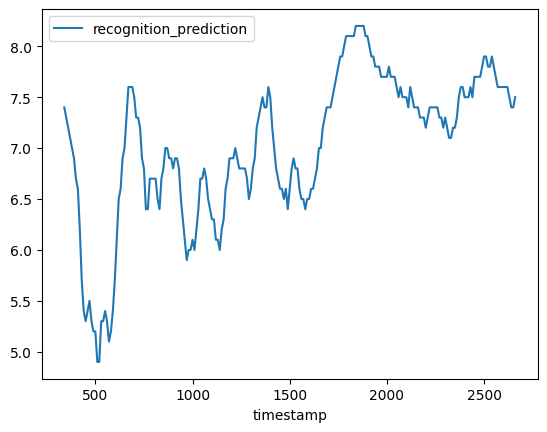

In [55]:
recognition_ma = recognition_sec.rolling(window=10).mean().dropna()
recognition_ma.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='time_group'>

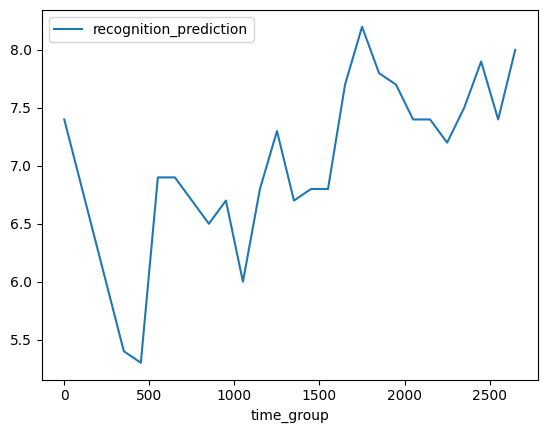

In [56]:
recognition_block = recognition_sec.groupby('time_group')[['recognition_prediction']].mean()
recognition_block.plot(y='recognition_prediction', use_index=True)

#### % people recognized (on detected)

<Axes: xlabel='timestamp'>

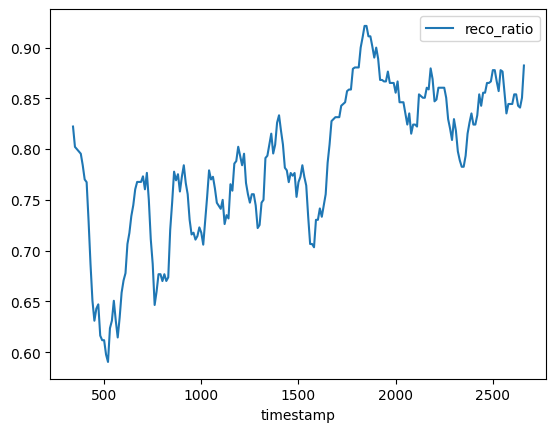

In [57]:
recognized_from_detected_ma = (recognition_ma['recognition_prediction'] / detection_ma['face_idx']).to_frame('reco_ratio')
recognized_from_detected_ma.plot()

## Individual metrics

In [58]:
target_person = 'Juliette'
person_mask = attention_df['recognition_prediction'] == target_person

In [59]:
# Creating a dataframe with all timestamps available even if person is not recognized
time_df = pd.DataFrame(timestamp_dict.items(), columns=['timestamp', 'time_group'])
person_filter_df = attention_df[person_mask].drop(columns='time_group')
person_df = pd.merge(time_df, person_filter_df, how='left', on='timestamp').set_index('timestamp')

### Detection/ Recognition

<Axes: xlabel='timestamp'>

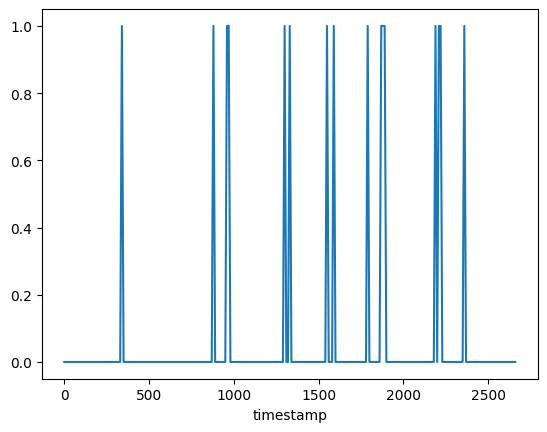

In [60]:
person_detection_sec = (~person_df['recognition_prediction'].isna()) * 1
person_detection_sec.plot()

<Axes: xlabel='timestamp'>

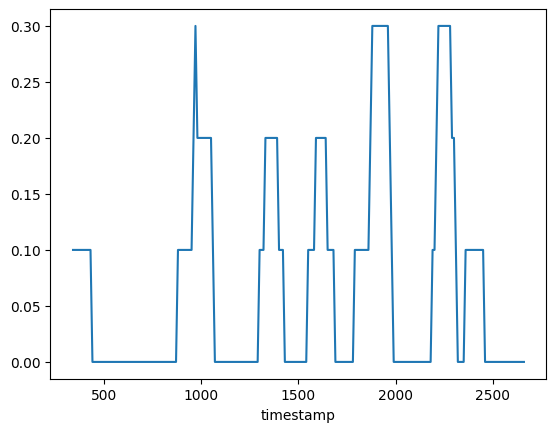

In [61]:
person_detection_ma = person_detection_sec.rolling(window=10).mean().dropna()
person_detection_ma.plot()

### Attention

In [62]:
person_attention_sec = person_df[['time_group', 'attentive']] * 1
# person_attention_sec.plot(y='attentive', use_index=True)

In [63]:
def average_nan(s: pd.Series, threshold: float = 0.4):
    na_rate = s.isna().sum() / len(s)
    return s.mean().round(2) if na_rate <= threshold else np.nan

<Axes: xlabel='time_group'>

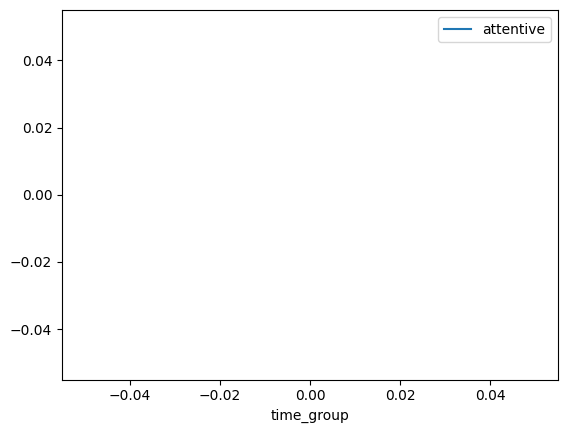

In [64]:
person_attention_block = person_attention_sec.groupby('time_group').agg(
    {'attentive': lambda s: average_nan(s, 0.3)}) 


person_attention_block.plot()

# FINETUNING

In [65]:
pd.set_option('display.max_rows', None)

In [66]:
attention_df.columns

Index(['frame', 'timestamp', 'time_group', 'face_idx',
       'recognition_prediction', 'recognition_distance', 'attentive',
       'left_prediction', 'left_score', 'right_prediction', 'right_score',
       'head_direction_prediction', 'head_direction_score',
       'head_inclination_prediction', 'head_inclination_score'],
      dtype='object')

In [67]:
mask_left = (attention_df['left_prediction'] == 'straight') & (attention_df['left_score'] >= 0.6) & (attention_df['right_score'] < 0.45)
mask_right = (attention_df['right_prediction'] == 'straight') & (attention_df['right_score'] >= 0.6) &(attention_df['left_score'] < 0.45)

In [68]:
focus_df = attention_df[['frame', 'timestamp','face_idx', 'recognition_prediction', 'left_prediction',	'left_score',	'right_prediction',	'right_score' ]][mask_left | mask_right]

In [69]:
focus_df

,frame,timestamp,face_idx,recognition_prediction,left_prediction,left_score,right_prediction,right_score
11,image_ds100,100,3,Sara,straight,0.60,straight,0.42
30,image_ds280,280,4,Gregorio,straight,0.38,straight,0.60
79,image_ds330,330,7,Isa,straight,0.35,straight,0.60
145,image_ds410,410,5,NaN,straight,0.60,straight,0.40
147,image_ds410,410,7,NaN,straight,0.60,straight,0.29
251,image_ds540,540,2,Sara,straight,0.60,straight,0.35
336,image_ds630,630,4,Gonzalo,straight,0.60,straight,0.42
354,image_ds650,650,3,NaN,straight,0.38,straight,0.60
385,image_ds680,680,3,Sara,straight,0.60,straight,0.44
408,image_ds710,710,1,Lancelot,straight,0.40,straight,0.60


In [70]:
#Saving focus dataframe
current_directory = os.getcwd()
data_test_directory = os.path.join(current_directory, os.pardir, "attention_data_test")
focus_df.to_csv(os.path.join(data_test_directory,'test_focus.csv'), index=False)

(array([ 1.,  1.,  0.,  2.,  2.,  1.,  2.,  2.,  0.,  9.,  7., 12., 24.,
         4., 28., 28.,  6., 23.,  6., 10., 20.,  9., 15., 18.,  4.,  6.,
         4.,  0.,  0.,  4.]),
 array([0.12      , 0.13633333, 0.15266667, 0.169     , 0.18533333,
        0.20166667, 0.218     , 0.23433333, 0.25066667, 0.267     ,
        0.28333333, 0.29966667, 0.316     , 0.33233333, 0.34866667,
        0.365     , 0.38133333, 0.39766667, 0.414     , 0.43033333,
        0.44666667, 0.463     , 0.47933333, 0.49566667, 0.512     ,
        0.52833333, 0.54466667, 0.561     , 0.57733333, 0.59366667,
        0.61      ]),
 <BarContainer object of 30 artists>)

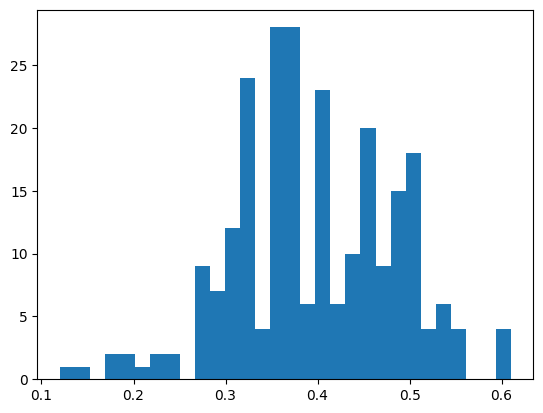

In [71]:
plt.hist(attention_df[attention_df['right_score'] > 0.6].left_score, bins=30)

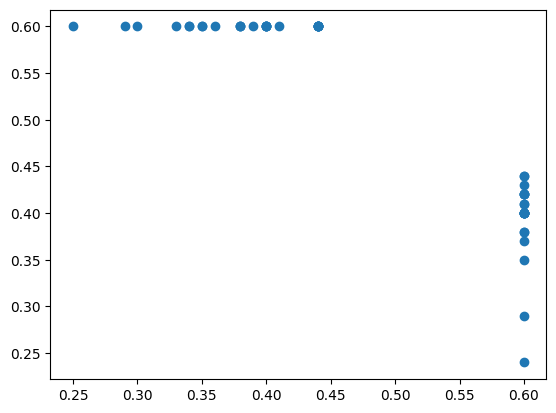

In [72]:
plt.scatter(x=focus_df['left_score'], y=focus_df['right_score'])

In [73]:
attention_df.columns

Index(['frame', 'timestamp', 'time_group', 'face_idx',
       'recognition_prediction', 'recognition_distance', 'attentive',
       'left_prediction', 'left_score', 'right_prediction', 'right_score',
       'head_direction_prediction', 'head_direction_score',
       'head_inclination_prediction', 'head_inclination_score'],
      dtype='object')

In [74]:
mask_head_down = (attention_df['head_inclination_prediction'] == 'head down')

In [75]:
focus_df = attention_df[['frame', 'timestamp','face_idx', 'recognition_prediction', 'attentive', 'head_inclination_prediction', 'head_inclination_score' ]][mask_head_down]

In [76]:
focus_df

,frame,timestamp,face_idx,recognition_prediction,attentive,head_inclination_prediction,head_inclination_score
4,image_ds0,0,4,NaN,False,head down,3.92
13,image_ds100,100,5,NaN,False,head down,3.86
22,image_ds270,270,6,NaN,False,head down,4.71
31,image_ds280,280,5,NaN,False,head down,4.08
39,image_ds290,290,4,NaN,False,head down,2.50
40,image_ds290,290,5,NaN,False,head down,3.92
49,image_ds300,300,5,NaN,False,head down,3.53
58,image_ds310,310,5,NaN,False,head down,4.25
59,image_ds310,310,6,NaN,False,head down,5.67
68,image_ds320,320,5,NaN,False,head down,8.50


In [77]:
#Saving focus dataframe
current_directory = os.getcwd()
data_test_directory = os.path.join(current_directory, os.pardir, "attention_data_test")
focus_df.to_csv(os.path.join(data_test_directory,'test_focus.csv'), index=False)

(array([18.,  7.,  5., 11., 17., 27., 39., 30., 20., 16.,  7., 10.,  9.,
         1.,  7.,  5.,  1.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 2.3       ,  2.58333333,  2.86666667,  3.15      ,  3.43333333,
         3.71666667,  4.        ,  4.28333333,  4.56666667,  4.85      ,
         5.13333333,  5.41666667,  5.7       ,  5.98333333,  6.26666667,
         6.55      ,  6.83333333,  7.11666667,  7.4       ,  7.68333333,
         7.96666667,  8.25      ,  8.53333333,  8.81666667,  9.1       ,
         9.38333333,  9.66666667,  9.95      , 10.23333333, 10.51666667,
        10.8       ]),
 <BarContainer object of 30 artists>)

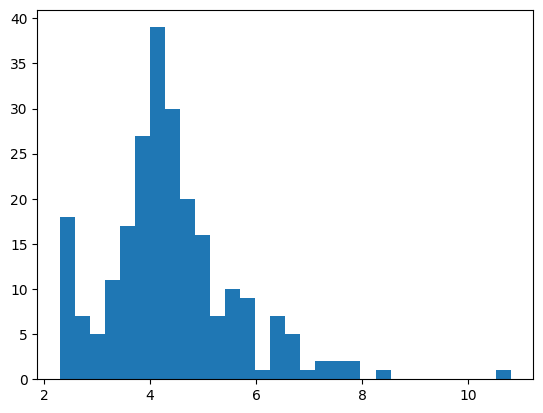

In [78]:
plt.hist(focus_df['head_inclination_score'], bins=30)

In [79]:
mask = focus_df['head_inclination_score'] > 2
focus_df[mask]

,frame,timestamp,face_idx,recognition_prediction,attentive,head_inclination_prediction,head_inclination_score
4,image_ds0,0,4,NaN,False,head down,3.92
13,image_ds100,100,5,NaN,False,head down,3.86
22,image_ds270,270,6,NaN,False,head down,4.71
31,image_ds280,280,5,NaN,False,head down,4.08
39,image_ds290,290,4,NaN,False,head down,2.50
40,image_ds290,290,5,NaN,False,head down,3.92
49,image_ds300,300,5,NaN,False,head down,3.53
58,image_ds310,310,5,NaN,False,head down,4.25
59,image_ds310,310,6,NaN,False,head down,5.67
68,image_ds320,320,5,NaN,False,head down,8.50


In [80]:
focus_df.to_csv(os.path.join(data_test_directory,'test_focus.csv'), index=False)